#Project age and gender detection

##Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Dropout, BatchNormalization

In [2]:
!nvidia-smi

Wed Jun  5 20:49:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Load the dataset

### Get the Data from Kaggle

In [ ]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yanncojan4777","key":"316b302be9cf03945387406859f25f8a"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
devarajv88/walmart-sales-dataset                                e-Commerce (Walmart) Sales Dataset                   5MB  2024-05-30 12:09:55           1812         29  1.0              
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data      7KB  2024-05-25 23:55:26           2802         49  1.0              
ayushparwal2026/country-population-from-1960-to-2022            Country Population from 1960 to 2022                75KB  2024-05-31 08:58:26           1409         37  0.9411765        
kanchana1990/vehicle-dataset-2024                               V

In [7]:
! kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 329M/331M [00:08<00:00, 22.0MB/s]
100% 331M/331M [00:08<00:00, 42.8MB/s]


In [8]:
! unzip utkface-new.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_

### Load the data and put it in a DataFrame

In [3]:
BASE_DIR = 'UTKFace'

In [4]:
#labels age gender ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
  image_path = os.path.join(BASE_DIR, filename)
  temp = filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
#Convert to Dataframe

df = pd.DataFrame()

df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df = df.loc[df['age'] <= 80]

df.head()

image  age  gender
0  UTKFace/25_0_3_20170117140644345.jpg.chip.jpg   25       0
1  UTKFace/62_0_1_20170113182604718.jpg.chip.jpg   62       0
2  UTKFace/56_0_1_20170113151553665.jpg.chip.jpg   56       0
3  UTKFace/26_1_1_20170113011613638.jpg.chip.jpg   26       1
4  UTKFace/22_0_1_20170117020724763.jpg.chip.jpg   22       0

In [6]:
#map labels gender
gender_dict = {0:'Male', 1:'Female'}

##Exploratery data analysis


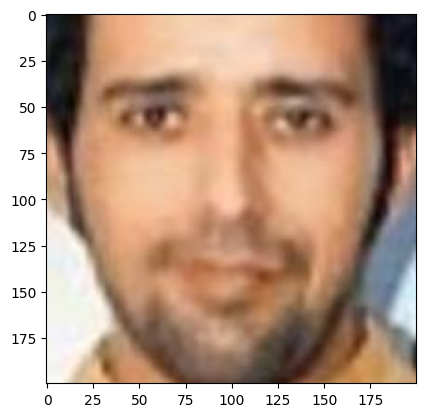

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

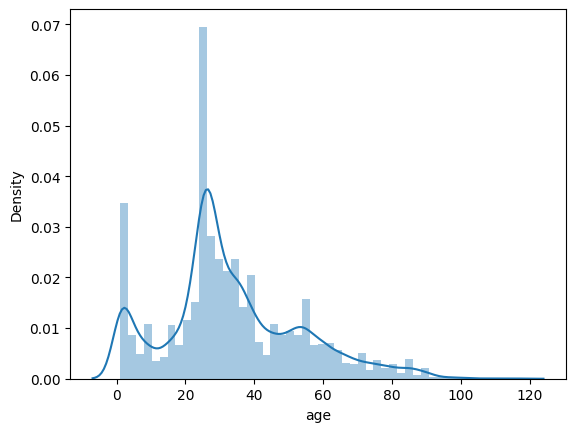

In [ ]:
sns.distplot(df['age'])

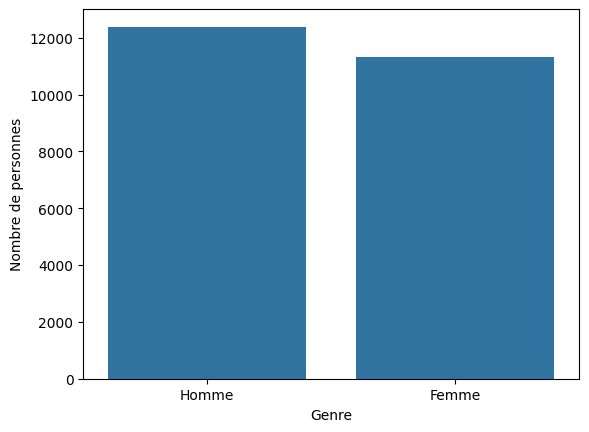

In [ ]:
sns.countplot(x='gender', data=df)
plt.xlabel('Genre')
plt.ylabel('Nombre de personnes')
plt.xticks([0, 1], ['Homme', 'Femme'])
plt.show()

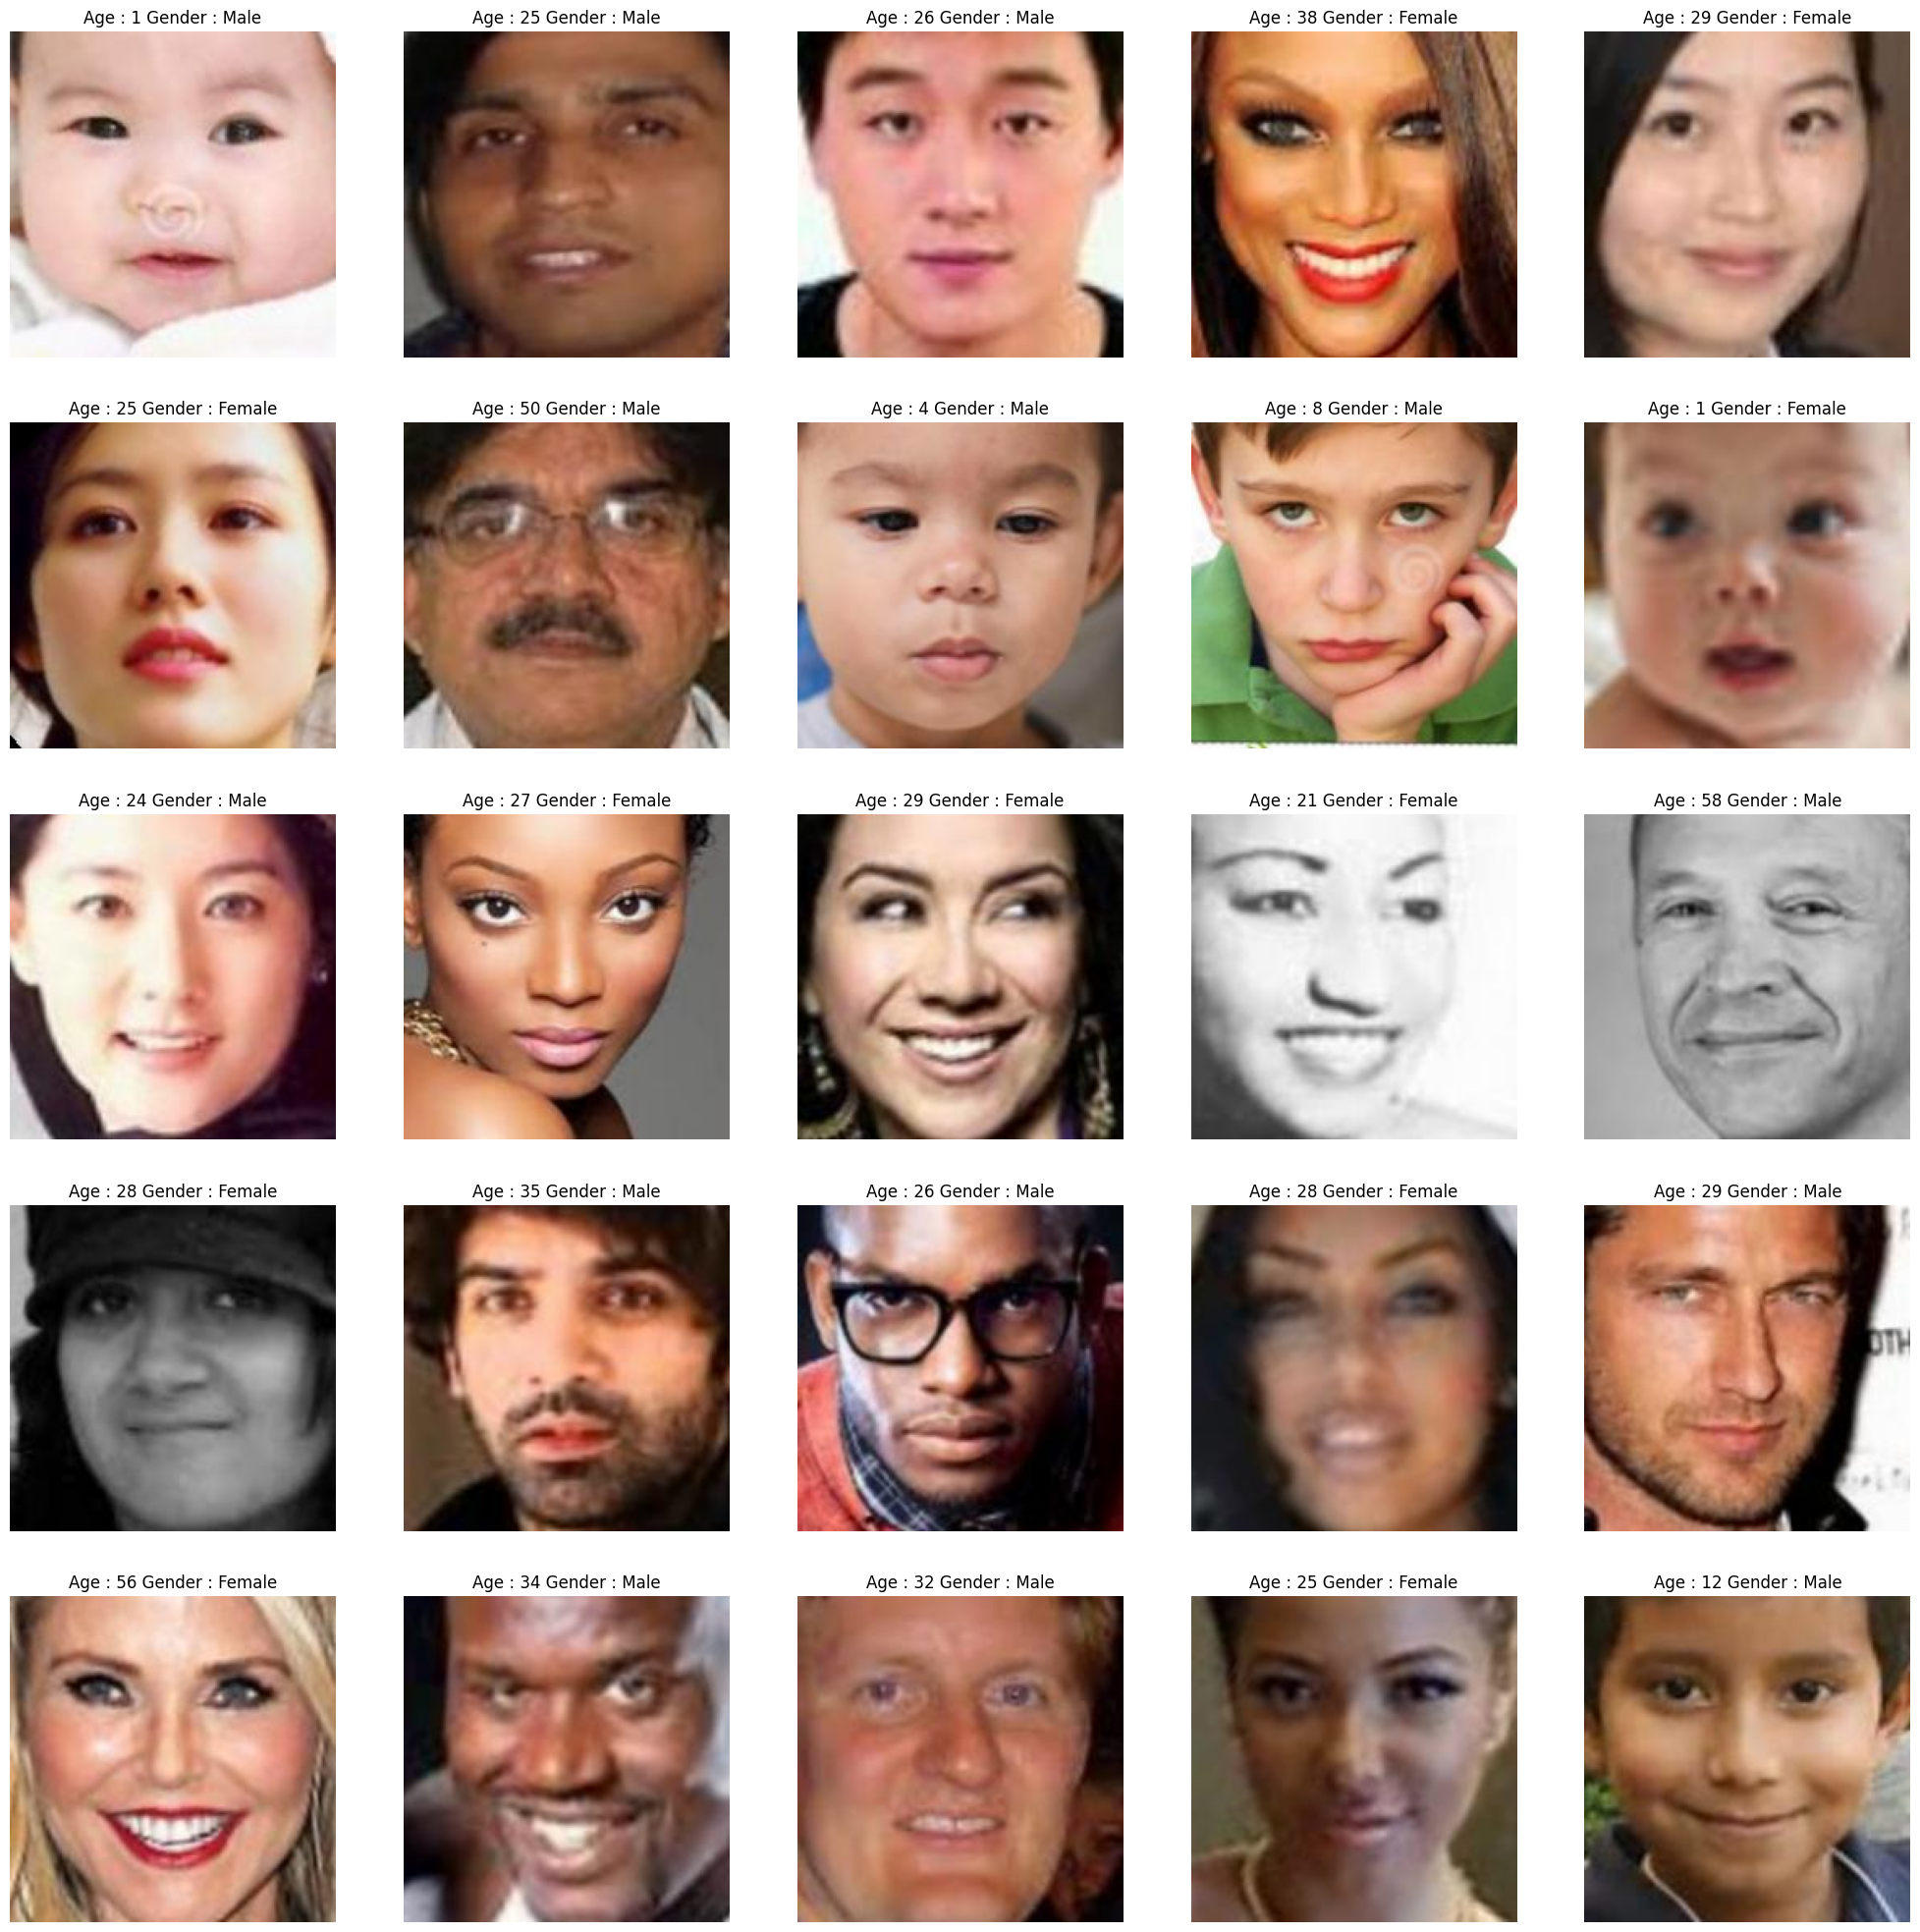

In [ ]:
#Display a grid of image
plt.figure(figsize=(25, 25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
  plt.subplot(5, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f'Age : {age} Gender : {gender_dict[gender]}')
  plt.axis('off')

## Features extraction

In [8]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, grayscale = True)
    img = img.resize((180, 180), Image.ANTIALIAS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 180, 180, 1)
  return features

In [9]:
X = extract_features(df['image'])

  0%|          | 0/23168 [00:00<?, ?it/s]

In [10]:
X.shape

(23168, 180, 180, 1)

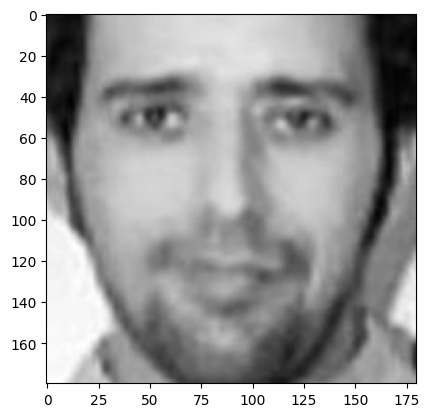

In [11]:
plt.imshow(X[0].squeeze(), cmap ='gray')
# Désactiver les axes
plt.show()

In [12]:
#normalize the images
X = (X / 255.0).astype(np.float16)

In [13]:
X[0][0][0][0].dtype

dtype('float16')

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (180, 180, 1)

##Model Creation
* Input -> image
* Out_put -> age and gender (2 output)

In [18]:
input_shape = (180, 180, 1)
inputs = Input(input_shape)

# Couches convolutionnelles avec Batch Normalization
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
conv_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
conv_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
conv_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
conv_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# Couches fully connected avec Dropout pour le genre
dense_1 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.4)(dense_1)  # Dropout de 40% des neurones

# Couches fully connected avec Dropout pour l'âge
dense_2 = Dense(256, activation='relu')(flatten)
dropout_2 = Dropout(0.4)(dense_2)  # Dropout de 40% des neurones

# Couches de sortie
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='Age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

optimizer = Adam(learning_rate=0.00005)

model.compile(
    loss=['binary_crossentropy', 'mae'],
    optimizer=optimizer,
    metrics={'gender_out': 'accuracy', 'Age_out': 'mae'}
)

In [17]:
"""
inputs = Input((input_shape))
#Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten() (maxp_4)

#fully connected layers

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name = 'Age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer = 'adam', metrics=['accuracy'])
"""

"\ninputs = Input((input_shape))\n#Convolutional layers\nconv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)\nmaxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)\nconv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)\nmaxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)\nconv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)\nmaxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)\nconv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)\nmaxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)\n\nflatten = Flatten() (maxp_4)\n\n#fully connected layers\n\ndense_1 = Dense(256, activation='relu') (flatten)\ndense_2 = Dense(256, activation='relu') (flatten)\n\ndropout_1 = Dropout(0.3) (dense_1)\ndropout_2 = Dropout(0.3) (dense_2)\n\noutput_1 = Dense(1, activation='sigmoid', name = 'gender_out') (dropout_1)\noutput_2 = Dense(1, activation='relu', name = 'Age_out') (dropout_2)\n\nmodel = Model(inputs=[inputs], outputs=[output_1, output_2])\n\nmodel.compile(loss=['b

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 180, 180, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 178, 178, 32)         320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 178, 178, 32)         128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)           0         ['batch_normalization_4[

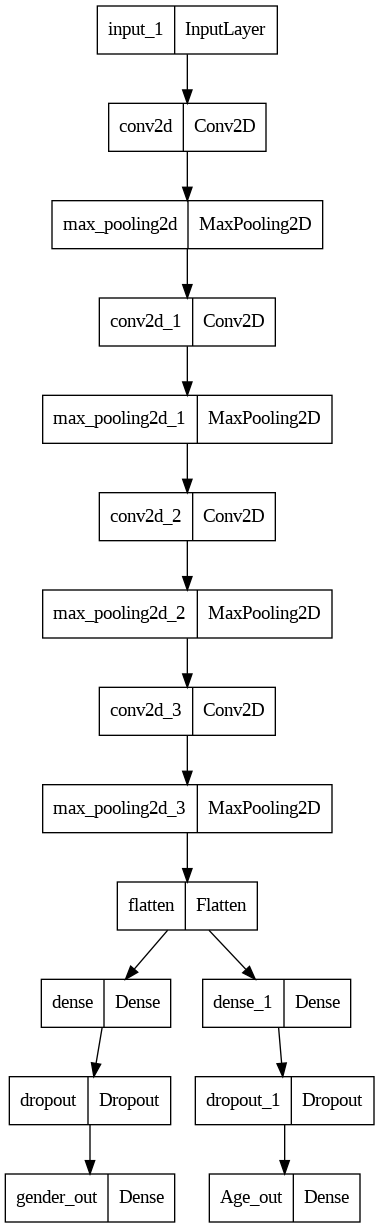

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)


Epoch 1/30
580/580 [==============================] - 44s 56ms/step - loss: 9.9154 - gender_out_loss: 0.4063 - Age_out_loss: 9.5091 - gender_out_accuracy: 0.8196 - Age_out_mae: 9.5091 - val_loss: 9.9297 - val_gender_out_loss: 0.2954 - val_Age_out_loss: 9.6343 - val_gender_out_accuracy: 0.8699 - val_Age_out_mae: 9.6343
Epoch 2/30
580/580 [==============================] - 30s 52ms/step - loss: 7.7151 - gender_out_loss: 0.2753 - Age_out_loss: 7.4397 - gender_out_accuracy: 0.8831 - Age_out_mae: 7.4397 - val_loss: 7.4163 - val_gender_out_loss: 0.2589 - val_Age_out_loss: 7.1574 - val_gender_out_accuracy: 0.8886 - val_Age_out_mae: 7.1574
Epoch 3/30
580/580 [==============================] - 30s 52ms/step - loss: 7.0593 - gender_out_loss: 0.2287 - Age_out_loss: 6.8306 - gender_out_accuracy: 0.9060 - Age_out_mae: 6.8306 - val_loss: 7.1229 - val_gender_out_loss: 0.2381 - val_Age_out_loss: 6.8849 - val_gender_out_accuracy: 0.8958 - val_Age_out_mae: 6.8849
Epoch 4/30
580/580 [====================

##Plot the result

In [21]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']


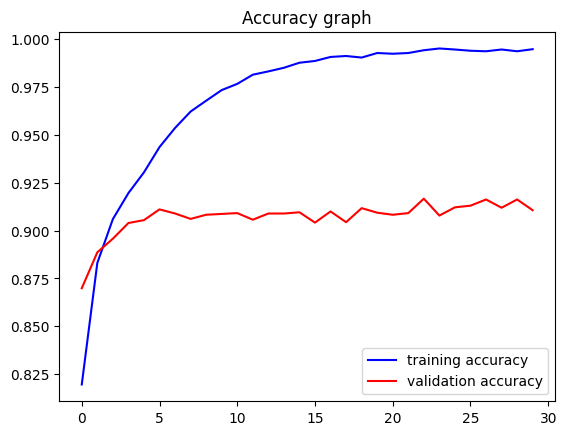

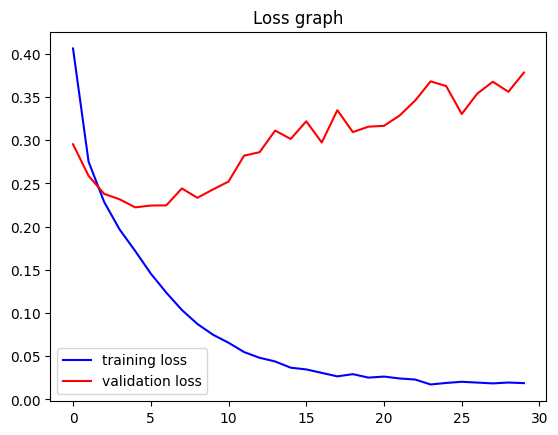

In [22]:
plt.plot(epochs, acc, 'b', label = 'training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'validation accuracy')
plt.title('Accuracy graph')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label = 'training loss')
plt.plot(epochs, val_loss, 'r', label = 'validation loss')
plt.title('Loss graph')
plt.legend()
plt.show()

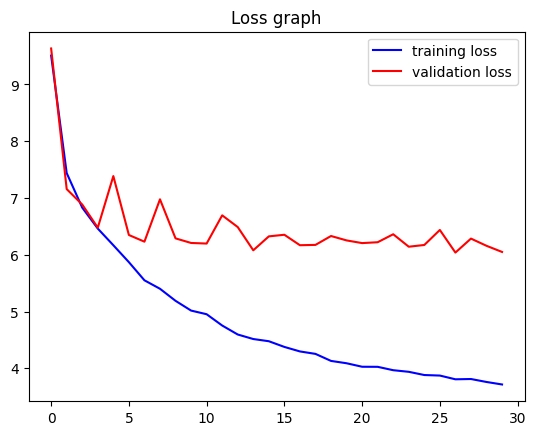

In [23]:
loss = history.history['Age_out_loss']
val_loss = history.history['val_Age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'training loss')
plt.plot(epochs, val_loss, 'r', label = 'validation loss')
plt.title('Loss graph')
plt.legend()
plt.show()

In [31]:
#Save the model
model.save('Model_age_gender_180v2.h5')

##Prediction with test data

Original gender:  Male Original age :  30
1/1 [==============================] - 0s 42ms/step
Predicted gender :  Male Predicted age :  29


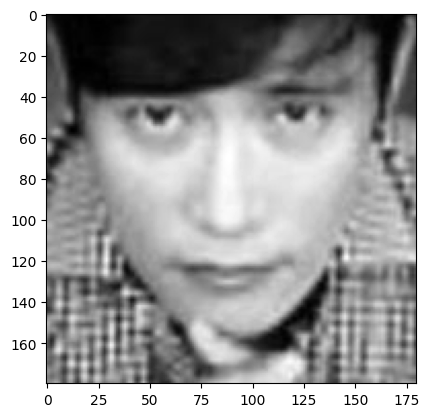

In [30]:
image_index = 123

#original data
print('Original gender: ', gender_dict[y_gender[image_index]], 'Original age : ', y_age[image_index])
#predict data
pred = model.predict(X[image_index].reshape(1, 180, 180, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted gender : ", pred_gender, "Predicted age : ", pred_age)
plt.imshow(X[image_index].reshape(180, 180), cmap = 'gray')

In [ ]:
X[image_index].shape


(128, 128, 1)